### Sensitivity analysis --> Sobol 
In this part of the sensitivity analysis, a Sobol analysis will be performed. The Sobol will find the variance each parameter has on the specified outcomes. 

In [50]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import ema_logging
from ema_workbench import Policy, MultiprocessingEvaluator, Samplers, SequentialEvaluator 
from SALib.analyze import sobol
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline
import numpy as np
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from problem_formulation import get_model_for_problem_formulation

from dike_model_function import DikeNetwork

In [44]:
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(6)

In [76]:
policies = [Policy(f"DikeIncrease_{i}", **{f"{dike}_DikeIncrease {n}": i for dike in dike_model.function.dikelist for n in dike_model.function.planning_steps}, **{"EWS_DaysToThreat": 2}) for i in range(1, 11)]

In [96]:
#Running experiments 
with SequentialEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100, policies=policies, uncertainty_sampling=Samplers.SOBOL)

#Adding outcomes to experiments dataframe
for keys in outcomes.keys():
    experiments[keys] = outcomes[keys]
    
#Saving sobol outcomes to csv file
experiments.to_csv("outcomes_sobol_2.csv")

C:\Users\anna\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 4000 scenarios * 10 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [5:19:07<00:00,  2.09it/s]
[MainProcess/INFO] experiments finished


In [99]:
experiments.to_csv("output/outcomes_sobol_2.csv")

In [100]:
experiments = pd.read_csv('output/outcomes_sobol_2.csv')
experiments.keys()

Index(['Unnamed: 0', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate',
       'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax',
       'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail',
       'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0',
       'discount rate 1', 'discount rate 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'scenario', 'policy', 'model', 'Expected Annual Damage',
       'Dike Investment Costs', 'RfR Investment Costs'],
      dtype='object')

In [82]:
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [101]:
#define outcomes of interest
ooi = ['Expected Annual Damage', 'Dike Investment Costs']

uncertainties = [
    'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
    'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
    'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
    'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
    'discount rate 2'
]

Performing Sobol analysis for Expected Annual Damage
                                   ST       ST_conf
A.0_ID flood wave shape  1.827792e-03  6.133485e-04
A.1_Bmax                 3.853490e-03  4.430988e-03
A.1_Brate                3.957769e-05  6.433112e-05
A.1_pfail                4.913384e-01  1.135718e-01
A.2_Bmax                 3.686345e-05  3.918309e-05
A.2_Brate                2.943595e-06  3.568277e-06
A.2_pfail                1.442098e-02  8.084505e-03
A.3_Bmax                 5.848558e-06  8.579019e-06
A.3_Brate                5.915839e-08  6.840679e-08
A.3_pfail                1.299818e-01  4.770966e-02
A.4_Bmax                 1.489281e-05  2.518417e-05
A.4_Brate                1.351434e-06  2.440710e-06
A.4_pfail                6.331383e-04  2.924145e-04
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                1.447426e-02  6.501992e-03
discount rate 0          1.905616e-02  6.015348e-03
discount ra

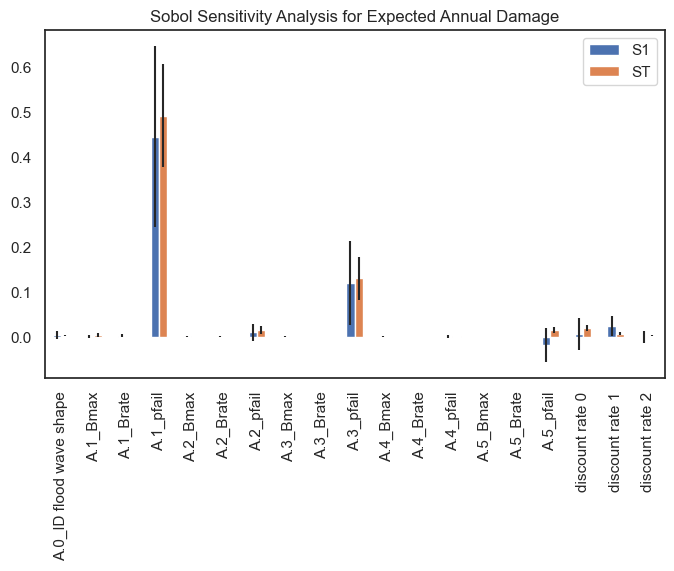

Performing Sobol analysis for Dike Investment Costs
                          ST  ST_conf
A.0_ID flood wave shape  0.0      0.0
A.1_Bmax                 0.0      0.0
A.1_Brate                0.0      0.0
A.1_pfail                0.0      0.0
A.2_Bmax                 0.0      0.0
A.2_Brate                0.0      0.0
A.2_pfail                0.0      0.0
A.3_Bmax                 0.0      0.0
A.3_Brate                0.0      0.0
A.3_pfail                0.0      0.0
A.4_Bmax                 0.0      0.0
A.4_Brate                0.0      0.0
A.4_pfail                0.0      0.0
A.5_Bmax                 0.0      0.0
A.5_Brate                0.0      0.0
A.5_pfail                0.0      0.0
discount rate 0          0.0      0.0
discount rate 1          0.0      0.0
discount rate 2          0.0      0.0
                          S1  S1_conf
A.0_ID flood wave shape  0.0      0.0
A.1_Bmax                 0.0      0.0
A.1_Brate                0.0      0.0
A.1_pfail                0.0      0.

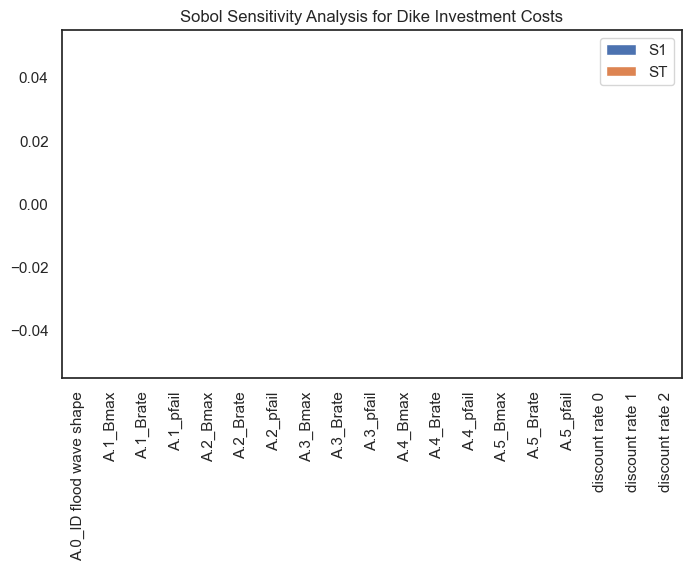

In [102]:
#analysing and plotting the sobol analysis for all outcomes of interest
problem = {
    'num_vars': len(uncertainties),
    'names': uncertainties,
    'bounds': [[0, 1]] * len(uncertainties)  # Assuming all uncertainties are normalized between 0 and 1
}

for outcome in ooi:
    print(f"Performing Sobol analysis for {outcome}")
    Si = sobol.analyze(problem, experiments[outcome].to_numpy(), calc_second_order=True, print_to_console=True)

    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]
    print(indices)

    indices.plot.bar(yerr=err.values.T, ax=ax)
    ax.set_title(f'Sobol Sensitivity Analysis for {outcome}')
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()
    fig.savefig(f'Sobol for {outcome}')

In [86]:
dike_final_sobol = outcomes["Expected Annual Damage"]
dike_mean_sobol = np.mean(outcomes["Expected Annual Damage"])
dike_std_sobol = np.std(outcomes["Expected Annual Damage"])

In [90]:
scores = feature_scoring.get_ex_feature_scores(experiments, dike_final_sobol, 
                                    max_features=0.6, mode=RuleInductionType.REGRESSION)[0]                                         
scores

C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


,1
0,
Expected Annual Damage,0.536403
A.1_pfail,0.110288
A.5_DikeIncrease 2,0.024862
A.2_DikeIncrease 2,0.022557
A.1_DikeIncrease 0,0.020386
policy,0.019098
A.3_DikeIncrease 0,0.016693
A.5_DikeIncrease 1,0.016415
A.3_pfail,0.015507


C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
C:\Users\anna\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encou

                             100       200       300       400       500   \
0                                                                           
A.3_pfail                0.304143  0.113963  0.092980  0.101679  0.088796   
discount rate 0          0.185170  0.022810  0.010095  0.018069  0.020546   
A.2_pfail                0.146045  0.039627  0.034391  0.018922  0.023054   
discount rate 2          0.120843  0.004088  0.007508  0.013724  0.009572   
A.5_Bmax                 0.064897  0.012210  0.028419  0.028721  0.039589   
A.4_Brate                0.053124  0.024756  0.021932  0.040751  0.049182   
A.5_pfail                0.029806  0.087732  0.070272  0.032673  0.024560   
A.4_pfail                0.021054  0.029207  0.031396  0.019409  0.020173   
A.3_Bmax                 0.013977  0.007757  0.032926  0.024752  0.031547   
A.1_pfail                0.013568  0.282986  0.408048  0.546027  0.466152   
A.1_Bmax                 0.010597  0.004818  0.021761  0.012051  0.029456   

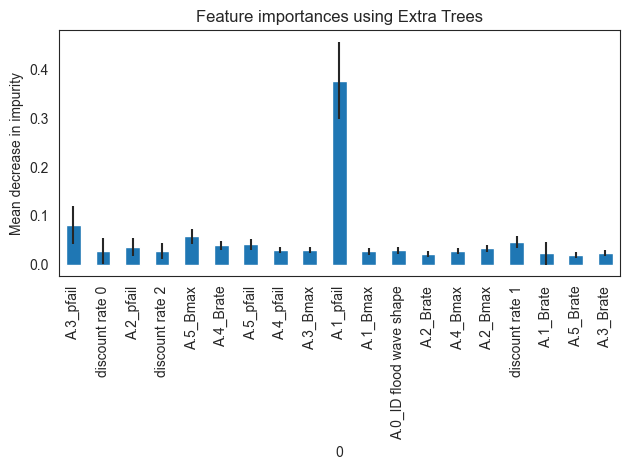

In [92]:
X = experiments[uncertainties]
combined_scores = []

# Perform feature scoring in batches
for j in range(100, experiments.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(
        X.iloc[0:j, :], 
        experiments[ooi[0]].iloc[0:j],
        max_features=0.6,
        mode=RuleInductionType.REGRESSION
    )[0]
    scores.columns = [j]
    combined_scores.append(scores)

# Combine scores
combined_scores_df = pd.concat(combined_scores, axis=1)
print(combined_scores_df)

# Plot the feature importances
combined_scores_mean = combined_scores_df.mean(axis=1)
combined_scores_std = combined_scores_df.std(axis=1)

sns.set_style('white')
fig, ax = plt.subplots()
combined_scores_mean.plot.bar(yerr=combined_scores_std, ax=ax)
ax.set_title("Feature importances using Extra Trees")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
fig.savefig('ExtraTrees_FeatureImportance.png')

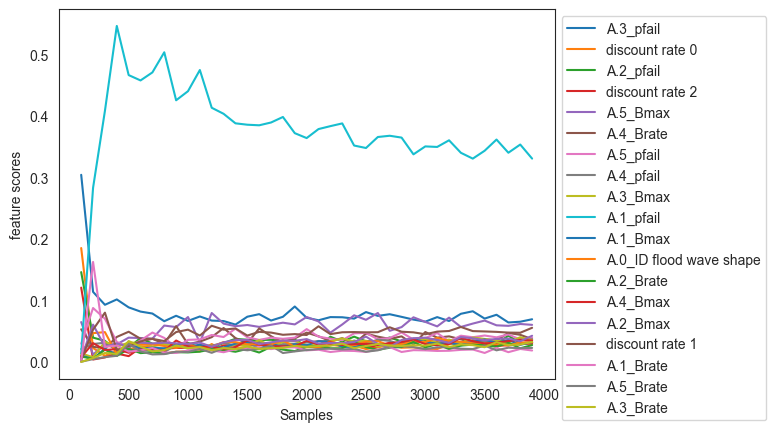

In [93]:
fig, ax = plt.subplots(1)

combined_scores_df.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()

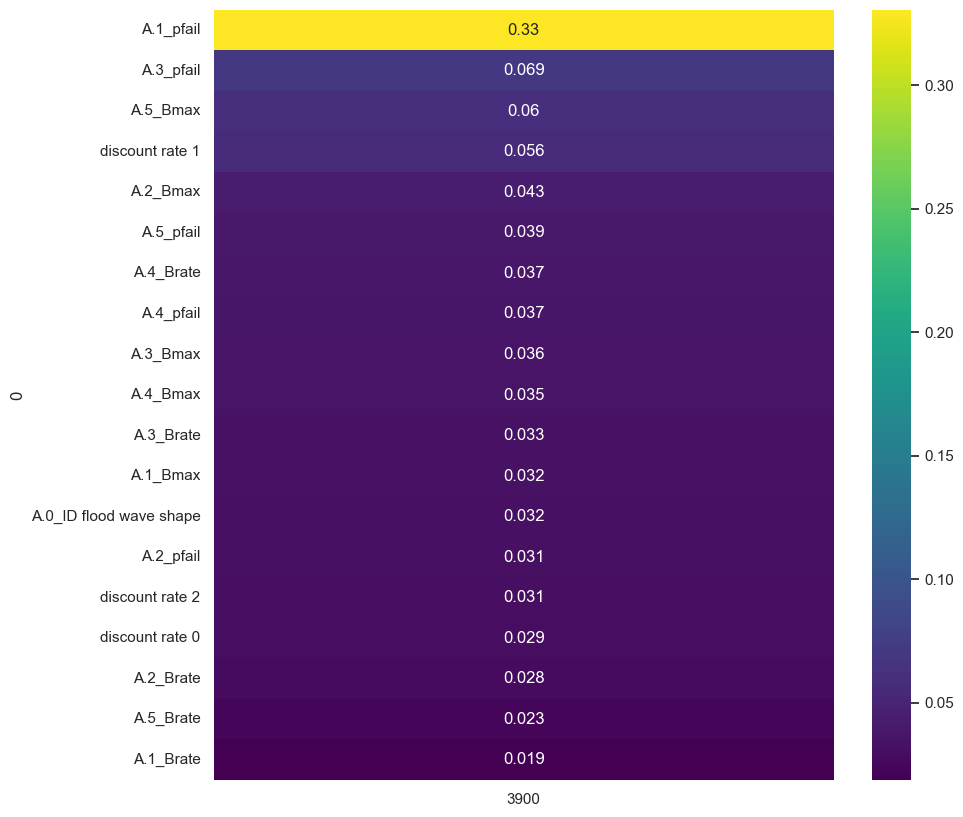

In [97]:
# Plot feature scores for all objectives of both gorssel and rijkswaterstaat

sns.set(rc = {'figure.figsize':(10,10)})
svm=sns.heatmap(scores, cmap="viridis", annot=True)
plt.show()
figure = svm.get_figure()    
figure.savefig('svm_conf.png', dpi=400, bbox_inches='tight')

In [98]:
sns.set(rc = {'figure.figsize':(10,10)})
svm=sns.heatmap(combined_scores, cmap="viridis", annot=True)
plt.show()
figure = svm.get_figure()    
figure.savefig('svm_conf.png', dpi=400, bbox_inches='tight')

ValueError: Must pass 2-d input. shape=(39, 19, 1)